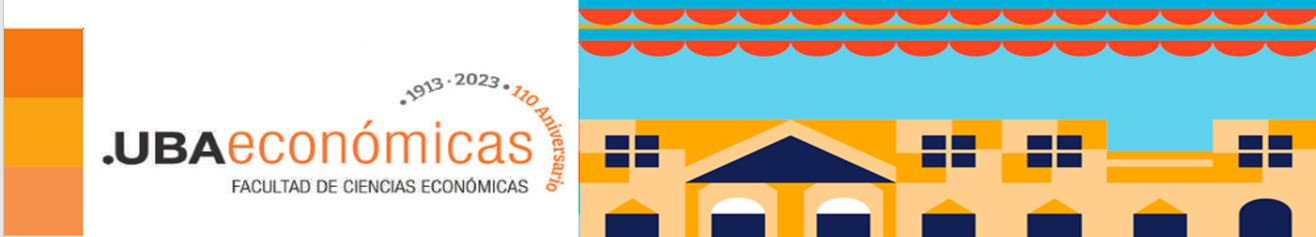

**GESTIÓN DE DATOS EN ORGANIZACIONES - 2DO ENCUENTRO INTERDISCIPLINAR**

**El arte de predecir: Forecasting de Series Temporales mediante Machine Learning en Python**

Rodrigo Del Rosso

# Script 2 - XGBoost


**Objetivo del Ejercicio**:  
Nos centraremos en el problema del consumo de energía, donde, dado un conjunto de datos suficientemente grande del consumo diario de energía de diferentes hogares en una ciudad, tenemos la tarea de predecir con la mayor precisión posible las demandas energéticas futuras.  

El dataset contiene el consumo de energía de 5.567 hogares seleccionados al azar en la ciudad de Londres durante el período comprendido entre noviembre de 2011 y febrero de 2014.  

Nota: Como queremos predecir el consumo de forma general y no por hogar, debemos agrupar los resultados por fecha y promediar los kilovatios-hora.

Carga de Librerías

In [1]:
import pandas as pd
import requests
from io import BytesIO
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

In [4]:
# URL del archivo ZIP en GitHub
zip_url = 'https://raw.githubusercontent.com/rodrigodelrosso/Taller-Datos/main/london_energy.csv.zip?raw=true'

# Descargar el archivo ZIP
response = requests.get(zip_url)
if response.status_code == 200:
    # Leer el contenido del archivo ZIP en un objeto BytesIO
    zip_content = BytesIO(response.content)

    # Descomprimir el archivo ZIP y extraer el archivo CSV
    with zipfile.ZipFile(zip_content, 'r') as zip_file:
        # Supongamos que el archivo CSV dentro del ZIP se llama 'archivo.csv'
        csv_file_name = 'london_energy.csv'
        with zip_file.open(csv_file_name) as csv_file:
            # Leer el archivo CSV en un DataFrame
            df = pd.read_csv(csv_file)

    # Mostrar la información del DataFrame
    df.info()
else:
    print("Error al descargar el archivo ZIP")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   LCLid   object 
 1   Date    object 
 2   KWH     float64
dtypes: float64(1), object(2)
memory usage: 80.3+ MB


`LCLid` es una cadena única que identifica a cada hogar.   
`Date` variable tiempo.  
`KWH` es el número total de kilovatios-hora gastados en esa fecha y no falta ningún valor.

# Carga y Procesamiento inicial del dataset

In [5]:
df.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [6]:
print(df.isna().sum())

LCLid    0
Date     0
KWH      0
dtype: int64


In [7]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


In [8]:
df_avg_consumption.head()

,date,consumption
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805


In [9]:
df_avg_consumption.tail()

,date,consumption
824,2014-02-24,10.411403
825,2014-02-25,10.294997
826,2014-02-26,10.202945
827,2014-02-27,10.356350
828,2014-02-28,0.417993


<Axes: xlabel='date'>

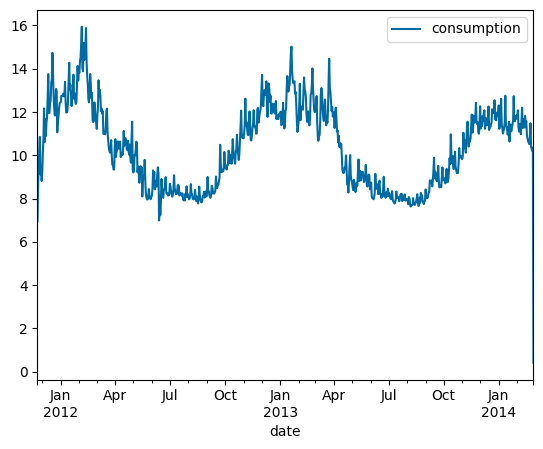

In [10]:
df_avg_consumption.plot(x="date", y="consumption")

Estacionalidad

Aca hacemos un gráfico que muestra cómo varía el consumo dentro del año 2012 para los datos df_avg_consumption.

<Axes: xlabel='date'>

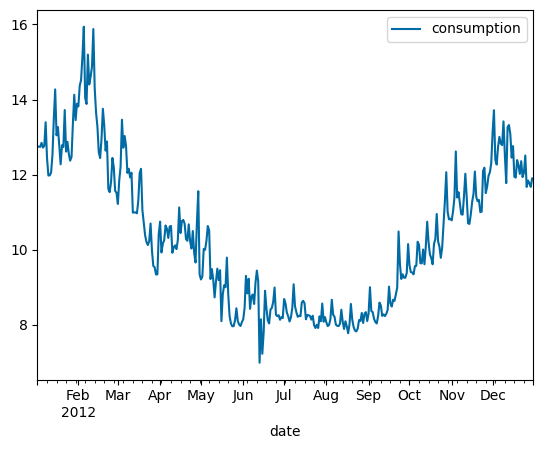

In [11]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")

**Feature Enginering**

De manera similar al ejercicio anterior....Para entrenar un modelo como XGBoost y LightGB ayuda crear las funciones nosotros mismos. Actualmente, solo tenemos una característica: la fecha completa. Podemos extraer diferentes características en función de la fecha completa como el día de la semana, el día del año, el mes y otros.

In [12]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


**Separación de los datos para el modelado:**

Para el conjunto de pruebas usaremos solo los últimos 6 meses. Si el conjunto de entrenamiento fuera más grande, habríamos utilizado todo el último año como conjunto de pruebas.

In [13]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 7)
(216, 7)


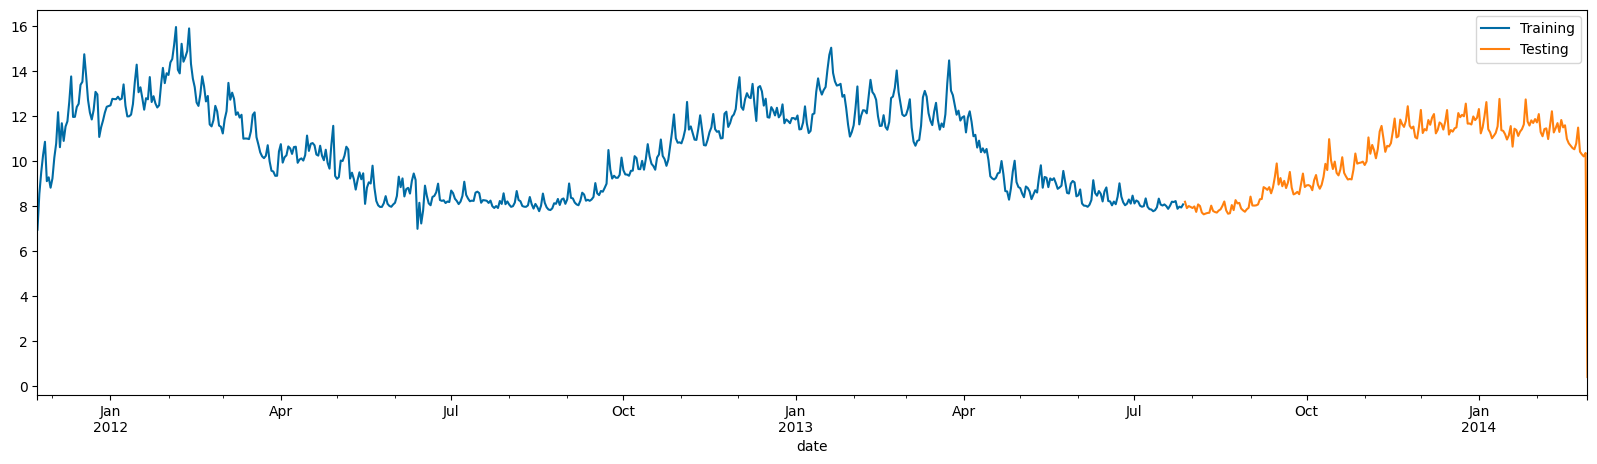

In [14]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [15]:
# Aca preparamos los datos para entrenar y evaluar , eliminando la columna de date y
# seleccionando características relevantes (day_of_week, day_of_year, month, quarter, year) junto con la variable objetivo (consumption)
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

**Entrenamiento del modelo:**


La optimización de los hiperparámetros se realizará con gridsearch, la cual toma parámetros y algunos valores como configuración y prueba todas las combinaciones posibles.

Nuevamente, debido a la naturaleza del problema, no podemos simplemente usar una validación cruzada simple de k veces. Scikit learn proporciona el método TimeSeriesSplit que divide los datos de forma incremental de manera respetuosa en términos de continuidad.

**Para Xgboost:**

In [16]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)   # hace cross validation , sin gap, para 4 splits y 100 observaciones para test
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

**Evaluación**

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

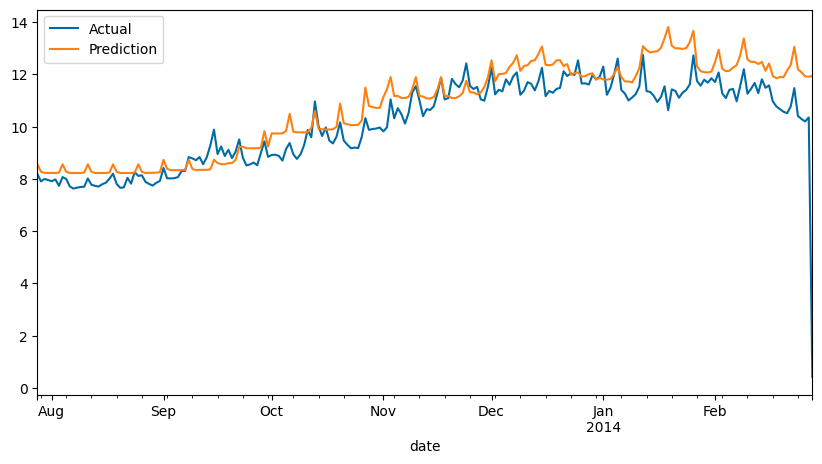

MAE: 0.7219302336224763
MSE: 1.2932143495490114
MAPE: 0.19288241474216378


In [18]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test) # Aca hace la predicción de la variable objetivo utilizando el mejor modelo encontrado por GridSearchCV
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Y para LighGBM**

In [19]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [50, 100, 300, 500, 700, 900, 1000],
                         'num_leaves': [10, 20, 30, 40, 100, 120]})

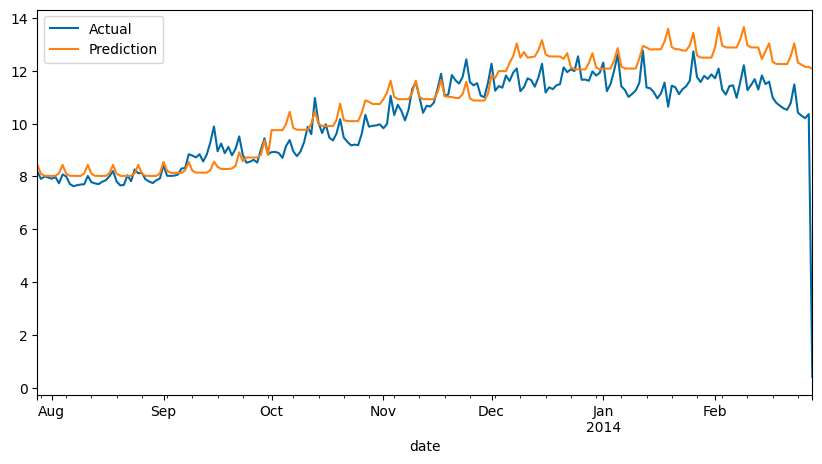

MAE: 0.7598511155488689
MSE: 1.4174602236853142
MAPE: 0.19624274959783336


In [20]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**¿Cómo mejoramos el rendimiento de los modelos?**

Utilizararemos funciones auxiliares que estén correlacionadas directa o indirectamente con el consumo de energía. Como por ejemplo datos del servicio meteorologico de Londres:

Fuente del dataset:https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023

In [21]:
url = 'https://raw.githubusercontent.com/rodrigodelrosso/Taller-Datos/main/london_weather.csv'
df_weather = pd.read_csv(url)
print(df_weather.isna().sum())
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


Hay varios datos faltantes que es necesario completar. Como tenemos datos meteorológicos en los que cada día depende del día anterior y del siguiente, completaremos esos valores interpolando. Además, convertiremos la columna "fecha" a "fecha y hora" y, luego, fusionaremos los dos datasets para obtener uno mejorado.

In [35]:
# Aqui hacemos varias operaciones para preprocesar y combinar conjuntos de datos

# trabajando con las fechas
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

# Llenar valores faltantes mediante interpolación-operacion por fuera de la materia
df_weather = df_weather.interpolate(method="ffill")

# marge del DataFrame df_avg_consumption con el DataFrame df_weather
df_avg_consumption = df_avg_consumption.merge(df_weather, how="inner", on="date")
df_avg_consumption.head()

<ipython-input-35-5ae6fa98ccf8>:7: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather = df_weather.interpolate(method="ffill")


,date,consumption,day_of_week,day_of_year,month,quarter,year,cloud_cover_x,sunshine_x,global_radiation_x,...,snow_depth_y,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,2,327,11,4,2011,7.0,2.0,35.0,...,0.0,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,3,328,11,4,2011,3.0,2.0,35.0,...,0.0,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,4,329,11,4,2011,3.0,5.0,52.0,...,0.0,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,5,330,11,4,2011,4.0,0.7,24.0,...,0.0,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,6,331,11,4,2011,3.0,5.9,55.0,...,0.0,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


**Separación de los datos del nuevo dataset:**

In [36]:
training_mask = df_avg_consumption['date'] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption['date'] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 34)
(216, 34)


In [37]:
# elimina columna `date`
training_data = training_data.drop(columns=['date'])

testing_dates = testing_data['date']
testing_data = testing_data.drop(columns=['date'])

X_train = training_data[['day_of_week', 'day_of_year', 'month', 'quarter', 'year',\
                         'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',\
                         'mean_temp', 'min_temp', 'precipitation', 'pressure',\
                         'snow_depth']]

y_train = training_data["consumption"]


X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_test = testing_data["consumption"]

**Entrenamiento**

In [38]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

**Evaluación**

In [39]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

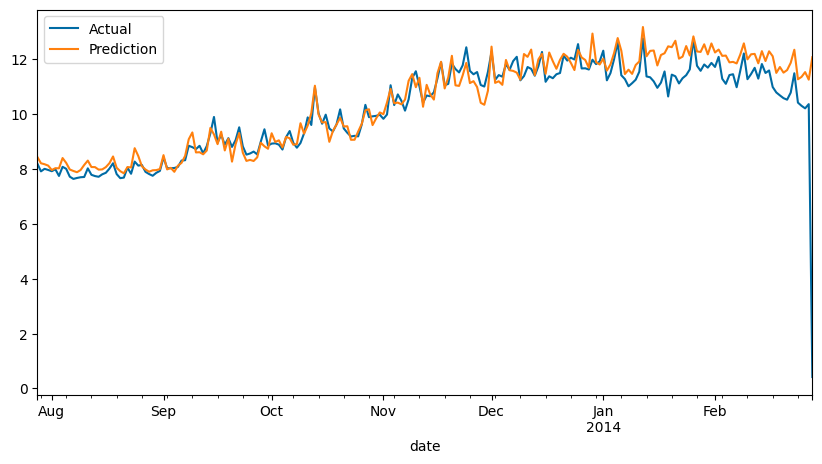

MAE: 0.4237410901122587
MSE: 0.8644555815084158
MAPE: 0.16432065473507365


In [40]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Para LightGBM**

In [41]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [50, 100, 300, 500, 700, 900, 1000],
                         'num_leaves': [10, 20, 30, 40, 100, 120]})

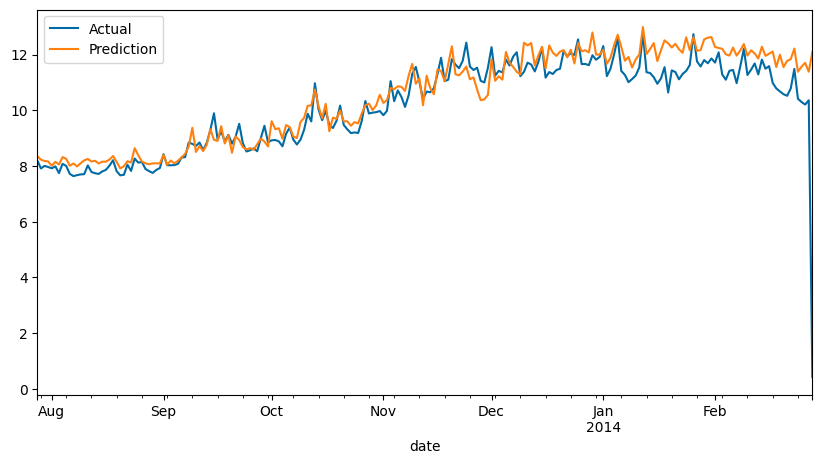

MAE: 0.476487191053889
MSE: 0.9170412738351784
MAPE: 0.16983133657848068


In [42]:
# Evaluación de los resultados de GridSearch
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Resumen**

**Modelo 1 XGBRegressor**
MAE: 0.7330404137119078
MSE: 1.3902031538115365
MAPE: 0.1929515940113626

**Modelo 2 LGBMRegressor**
MAE: 0.7598511155488689
MSE: 1.4174602236853142
MAPE: 0.19624274959783336

**Modelo 3 XGBRegressor (con mas variables)**
MAE: 0.41222399123657294
MSE: 0.8432288584575132
MAPE: 0.16246850639888177

**Modelo 4 LGBMRegressor (con mas variables)**
MAE: 0.476487191053889
MSE: 0.9170412738351784
MAPE: 0.16983133657848068
………………………………

Comparación de resultados =

Modelo 3 (XGBRegressor con más variables) tiene el menor MAE (0.412) y MSE (0.843), lo que podria indicar que tiene las predicciones más precisas.
Modelo 3 (XGBRegressor con más variables) también tiene el menor MAPE (0.162), lo que tambien podria indicar que es mejor ya que tiene el menor error porcentual promedio en las predicciones.
